In [ ]:
conda install -c conda-forge imbalanced-learn

In [ ]:
conda install -c conda-forge statsmodels

In [ ]:
conda install -c conda-forge textblob

In [4]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from textblob import TextBlob

In [5]:
df = pd.read_csv('mbti_1.csv')

In [6]:
df.shape

(8675, 2)

In [7]:
print(df.iloc[0,1])

'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|

In [8]:
df.isnull().sum()

type     0
posts    0
dtype: int64

In [9]:
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [10]:
df['type'].value_counts()


INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

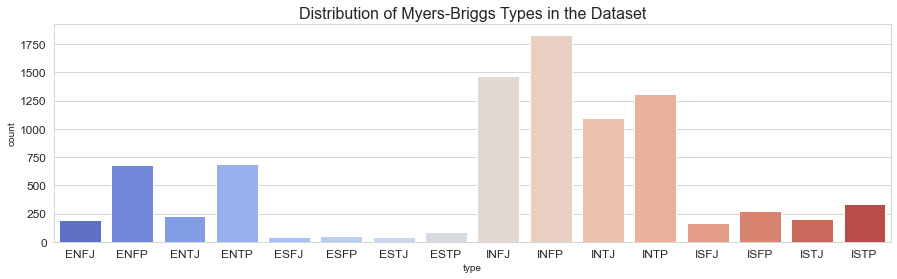

In [11]:
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.countplot(x="type", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Distribution of Myers-Briggs Types in the Dataset", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [13]:
print('Introversion (I) – Extroversion (E)', '\n', df['type'].map(lambda x: x[0]).value_counts(), '\n')
print('Intuition (N) – Sensing (S)', '\n', df['type'].map(lambda x: x[1]).value_counts(), '\n')
print('Thinking (T) – Feeling (F)', '\n', df['type'].map(lambda x: x[2]).value_counts(), '\n')
print('Judging (J) – Perceiving (P)', '\n', df['type'].map(lambda x: x[3]).value_counts(), '\n')

Introversion (I) – Extroversion (E) 
 I    6676
E    1999
Name: type, dtype: int64 

Intuition (N) – Sensing (S) 
 N    7478
S    1197
Name: type, dtype: int64 

Thinking (T) – Feeling (F) 
 F    4694
T    3981
Name: type, dtype: int64 

Judging (J) – Perceiving (P) 
 P    5241
J    3434
Name: type, dtype: int64 



**Preprocessing**

In [12]:
df_working = df.copy()
df_working.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [14]:
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging


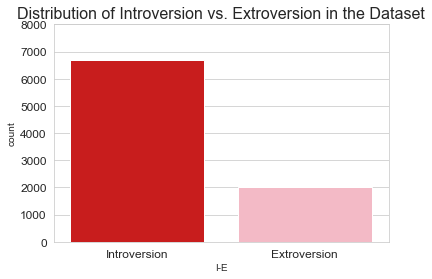

In [15]:

# Countplot of Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.countplot(x="I-E", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Distribution of Introversion vs. Extroversion in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

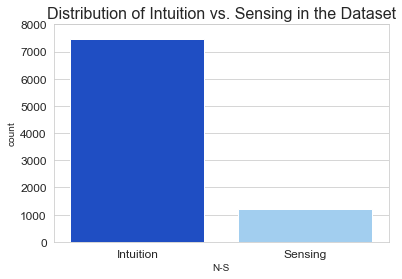

In [16]:
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.countplot(x="N-S", data=df_working, order=["Intuition", "Sensing"])
plt.title("Distribution of Intuition vs. Sensing in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

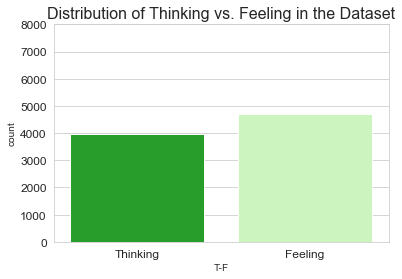

In [17]:
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.countplot(x="T-F", data=df_working, order=["Thinking", "Feeling"])
plt.title("Distribution of Thinking vs. Feeling in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

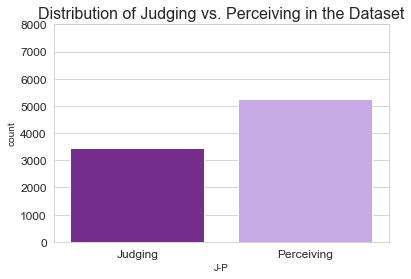

In [18]:
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.countplot(x="J-P", data=df_working, order=["Judging", "Perceiving"])
plt.title("Distribution of Judging vs. Perceiving in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [19]:
posts = df_working['posts'].copy()
posts = posts.apply(lambda x: x.replace('|||', ' ')) # replaces post separators with empty space
posts.head()

0    'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired. That's another silly misconcept...
Name: posts, dtype: object

In [20]:
# Run an initial CountVectorizer with default settings on the posts column to see what's there
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
cv.fit_transform(posts)

<8675x145412 sparse matrix of type '<class 'numpy.float64'>'
	with 4516646 stored elements in Compressed Sparse Row format>

In [21]:

# Convert the output of the transformation to a dense matrix
cv.transform(posts).todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.02296889, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [22]:
# Convert to a dataframe to get feature names and see the distribution of words
df_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())
df_posts.head()

,00,000,0000,000000,0000000000,000000000000000,00000000000000000000000000000000027,00000011,000000111,0000001111,...,ｓｏ,ｔｒｕｍｐu3000ｉｓu3000ａｎu3000ｅｓｔｐ,ｖａｐｏｒｗａｖｅ,ｗｈｙu3000ｉｓu3000ａｎｙｏｎｅu3000ｓｔｉｌｌu3000ｄｉｓｃｕｓｓｉｎｇu3000ｔｈｉｓ,ﾉωﾉ,ﾉｼ,ﾉﾞ,ﾉﾟ,ﾟдﾟщ,ﾟﾟ
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.022969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_posts.shape

(8675, 145412)

In [24]:
print(df_posts.sum().sort_values(ascending=False).head(10))

the     2020.634068
to      1999.732473
and     1598.174841
you     1240.025925
it      1225.249242
of      1212.870478
that    1069.374172
is       917.891457
in       862.048036
my       836.370454
dtype: float64


In [25]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muskankuchhal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/muskankuchhal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
def cleaner(text):
    #wordnet = WordNetLemmatizer()  
    stemmer=PorterStemmer()                                      # groups words having the same stems
    text = text.replace('|||', ' ')                                  # replaces post separators with empty space
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)  # replace hyperlink with 'URL'
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))      # removes digits
    text = text.lower().strip()                                      # convert to lower case
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [27]:
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp',
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
stop = stopwords.words('english')

for type in types:
    stop.append(type)
stop.append("url")
stop_rev = stop    
print(stop_rev)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
df.posts.iloc[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [29]:
cv =TfidfVectorizer(stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit(posts)
cv.transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), 
             columns=cv.get_feature_names())
df_posts.head()

,10,100,12,15,20,30,50,ability,able,absolutely,...,years ago,yep,yes,yesterday,yet,young,younger,youtu,youtube,youtube com
0,0.000000,0.0,0.0,0.0,0.029745,0.000000,0.034982,0.000000,0.000000,0.000000,...,0.029592,0.034213,0.000000,0.0,0.0,0.0,0.0,0.000000,0.275970,0.287410
1,0.039280,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.034096,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.027612,0.028756
2,0.050985,0.0,0.0,0.0,0.000000,0.068745,0.000000,0.127588,0.044255,0.106506,...,0.000000,0.000000,0.030210,0.0,0.0,0.0,0.0,0.000000,0.107517,0.111975
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.062322,0.000000,0.075887,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.061456,0.064003
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.053227,0.0,0.0,0.0,0.0,0.143167,0.031573,0.032882


In [30]:

# Examine the top 10 occuring words in this round of CountVectorizer
print(df_posts.sum().sort_values(ascending=False).head(10))

like      1082.616721
think      792.328017
people     770.419730
one        600.885605
know       599.339267
really     588.405660
would      581.920319
get        514.639626
com        511.499106
time       463.359987
dtype: float64


In [31]:
cleaner(df.posts.iloc[0])

'moment sportscent top ten play prank lifechang experi life repeat today may perc experi immers last thing friend post facebook commit suicid next day rest peac hello sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg dont mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item youv determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear favorit video game grow current favorit video game cool appear late sad there someon everyon wait thought confid good thing cherish time solitud bc revel within inner world wherea time id workin enjoy time dont worri peopl alway around yo ladi your complimentari personalitywel hey main social outlet xbox live convers even verbal fatigu quickli realli dig part

In [32]:
cv = TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit_transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), 
             columns=cv.get_feature_names())
df_posts.head()


/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abil,abl,absolut,accept,account,accur,across,act,action,activ,...,year old,yep,yesterday,yet,youd,youll,young,younger,youtub,youv
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.091883,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066060
1,0.000000,0.035780,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.134089,0.048485,0.108886,0.000000,0.0,0.067243,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.068667,0.038552,0.041127,0.0,0.000000,0.0,0.0,0.090761,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.044659,0.0,0.0,0.0,0.079451
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.057365,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [33]:
df_posts.shape

(8675, 1000)

In [34]:
print(df_posts.sum().sort_values(ascending=False).head(10))

im        1265.769936
like      1155.477329
think      891.134800
dont       818.336254
peopl      751.443689
one        628.374461
know       620.878488
get        617.492215
feel       605.201579
realli     573.758069
dtype: float64


In [35]:
# View the tokens created
with pd.option_context('display.max_rows', 1, 'display.max_columns', None):
    print(df_posts)

    abil  abl  absolut  accept  account  accur  across  act  action  activ  \
0    0.0  0.0      0.0     0.0      0.0    0.0     0.0  0.0     0.0    0.0   
..   ...  ...      ...     ...      ...    ...     ...  ...     ...    ...   

    actual  add  admit  advic  affect  afraid       age       ago  agre   ah  \
0      0.0  0.0    0.0    0.0     0.0     0.0  0.065257  0.055776   0.0  0.0   
..     ...  ...    ...    ...     ...     ...       ...       ...   ...  ...   

    allow  almost  alon  along  alreadi  also  although     alway  amaz  \
0     0.0     0.0   0.0    0.0      0.0   0.0       0.0  0.034277   0.0   
..    ...     ...   ...    ...      ...   ...       ...       ...   ...   

    amount  angri  anim  annoy  anoth  answer  answer question  anxieti  \
0      0.0    0.0   0.0    0.0    0.0     0.0              0.0      0.0   
..     ...    ...   ...    ...    ...     ...              ...      ...   

    anymor  anyon  anyon els  anyth  anyway  apart  apolog  appar    app

Classification

In [36]:
baseline = df['type'].value_counts().max() / df['type'].value_counts().sum()
baseline

0.21118155619596543

In [37]:

# Train-test split, using type variable as target and posts variable as predictor
X_train, X_test, y_train, y_test = train_test_split(df['posts'].values,
                                                   df['type'].values,
                                                   test_size=0.30, random_state=42)
print('X_train ', X_train.shape, '\n', 'X_test ', X_test.shape, '\n', 'y_train ', y_train.shape, '\n', 
      'y_test', y_test.shape)

X_train  (6072,) 
 X_test  (2603,) 
 y_train  (6072,) 
 y_test (2603,)


In [38]:
X_train[0]

"'Rivals of Aether. It's such a good alternative to Melee when you can't really afford to play it offline.|||Don't worry, I don't think debating is an actual issue. I don't really think of Chloe & Maxine as best friends, actually. They are quite different, and even if they used to be best friends as kids,...|||Max = INFP Warren = INTJ Jefferson = ENxJ Chloe = ISTP David = ISTJ Victoria = ESTJ Nathan = ISFx William = xNxP Frank = IxTJ|||Since I've seen quite a few people liking Life Is Strange, what is your idea on the characters type?  My guess would be : Maxine INFJ - Could just be my attracted by Maxine bias though :| Chloe...|||Just played Life is Strange 3rd episode.  That game is packed with so many feels, it's unbelievable. Favorite for 2015 without a doubt.|||Is that the INFJ-Friend-Hairstyling touch?|||Question to fellow INTJs : Have you ever thought of making MBTI your business?   Where I live (France) it seems under-developped while slowly growing, and I was wondering about m

In [39]:

# Run CountVectorizer on the X train/test ('posts' column) using the arguments identified earlier
cv = TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


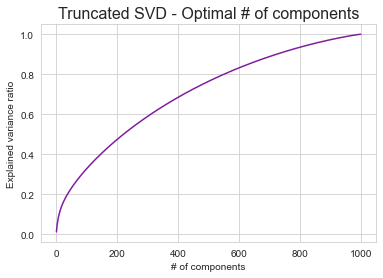

In [40]:
# First use max components and graph the explained variance ratio to find cutoff point 
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");

200 components


In [42]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(X_train_cv)
X_train_tsvd = tsvd.transform(X_train_cv)

X_test_cv = cv.transform(X_test)
X_test_tsvd = tsvd.transform(X_test_cv)

In [43]:

# Pipeline for the data preprocessing steps (CountVectorizer, TruncatedSVD) on the X data
pipeline_preprocessing = make_pipeline(
    TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

X_train_tsvd = pipeline_preprocessing.fit_transform(X_train)
X_test_tsvd = pipeline_preprocessing.transform(X_test)

/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [44]:
X_train_tsvd

array([[ 0.57849616,  0.06003531, -0.04304719, ..., -0.01775779,
        -0.01994005, -0.01600821],
       [ 0.6133611 , -0.03149231,  0.10851525, ...,  0.04426478,
        -0.04100336,  0.0247657 ],
       [ 0.36701839, -0.07211187,  0.08219324, ..., -0.02217992,
         0.03682023,  0.00443102],
       ...,
       [ 0.60683416,  0.10886673,  0.07456616, ..., -0.02359048,
         0.02267675, -0.02681354],
       [ 0.65661237, -0.09925585, -0.02523988, ...,  0.02410937,
        -0.02566128,  0.00587774],
       [ 0.38292251,  0.06552011, -0.13610037, ..., -0.01935078,
        -0.04324267,  0.01652675]])

In [45]:
# Fit and score a Random Forest Classifier
# Parameters: 30 estimators, min 50 samples per leaf node, out-of-bag samples to estimate generalization accuracy
rfc = RandomForestClassifier(n_estimators=30, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=123)
rfc.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", rfc.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, rfc.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", rfc.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, rfc.predict(X_test_tsvd)))

TRAINING SET
Accuracy:  0.4199604743083004
Confusion Matrix:
[[   0    0    0    0    0    0    0    0   38   86    0   10    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   86  365    8   20    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   36   69   16   52    0    0
     0    0]
 [   0    0    0    8    0    0    0    0   65  220   29  162    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    9   21    0    2    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   13   21    1    4    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    2   13    4    3    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   11   36    4   13    0    0
     0    0]
 [   0    0    0    0    0    0    0    0  540  453    7   36    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   33 1194    3   36    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   93  289  253  145    0    0
     0    0]
 [  

/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       134
        ENFP       0.00      0.00      0.00       479
        ENTJ       0.00      0.00      0.00       173
        ENTP       1.00      0.02      0.03       484
        ESFJ       0.00      0.00      0.00        32
        ESFP       0.00      0.00      0.00        39
        ESTJ       0.00      0.00      0.00        22
        ESTP       0.00      0.00      0.00        64
        INFJ       0.49      0.52      0.51      1036
        INFP       0.34      0.94      0.50      1266
        INTJ       0.70      0.32      0.44       780
        INTP       0.49      0.62      0.54       900
        ISFJ       0.00      0.00      0.00       105
        ISFP       0.00      0.00      0.00       187
        ISTJ       0.00      0.00      0.00       135
        ISTP       0.00      0.00      0.00       236

    accuracy                           0.42      6072
   macro avg       0.19   

/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [46]:
# Convert confusion matrix to a dataframe to prepare it for heatmapping
cm_rfc = np.array(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))

cm_randomforest = pd.DataFrame(cm_rfc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm_randomforest

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,0,0,0,0,0,0,0,0,11,44,0,1,0,0,0,0
ENFP,0,0,0,1,0,0,0,0,32,149,2,12,0,0,0,0
ENTJ,0,0,0,0,0,0,0,0,17,19,6,16,0,0,0,0
ENTP,0,0,0,0,0,0,0,0,40,96,7,58,0,0,0,0
ESFJ,0,0,0,0,0,0,0,0,3,7,0,0,0,0,0,0
ESFP,0,0,0,0,0,0,0,0,2,6,0,1,0,0,0,0
ESTJ,0,0,0,0,0,0,0,0,1,13,3,0,0,0,0,0
ESTP,0,0,0,0,0,0,0,0,4,17,1,3,0,0,0,0
INFJ,0,0,0,0,0,0,0,0,81,314,8,31,0,0,0,0
INFP,0,0,0,0,0,0,0,0,60,462,7,37,0,0,0,0


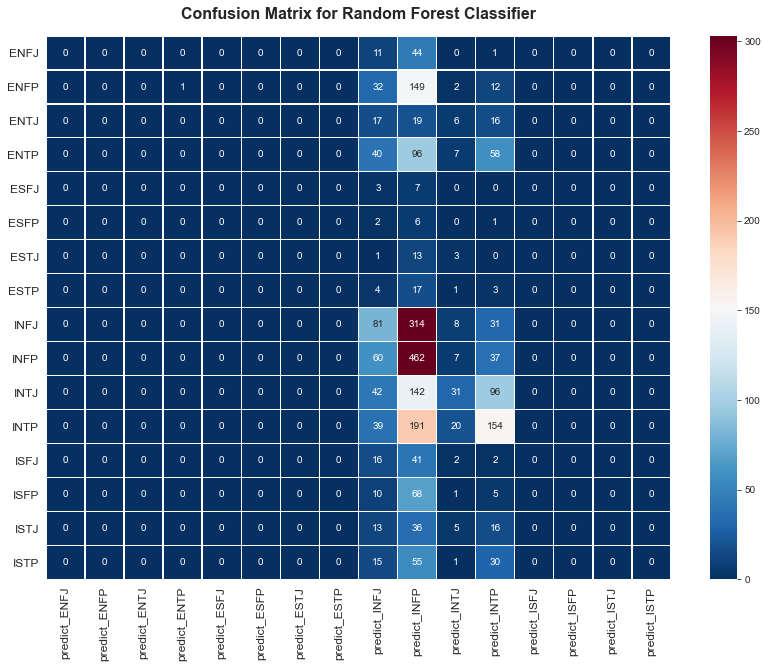

In [47]:
# Create confusion matrix heatmap of Random Forest Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16,
          fontweight='bold', y=1.02)
sns.heatmap(cm_randomforest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);


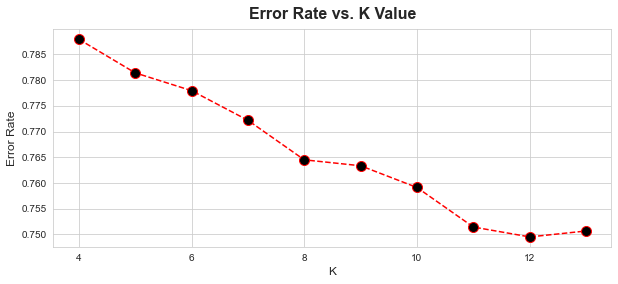

In [48]:
# Search for the optimal number of neighbors to use
error_rate = []

for i in range(4,14):
    knn_lc = KNeighborsClassifier(n_neighbors=i)
    knn_lc.fit(X_train_tsvd, y_train)
    
    pred_i = knn_lc.predict(X_test_tsvd)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10, 4))
plt.plot(range(4,14), error_rate, color='red', linestyle='dashed',
         marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value', fontsize=16,
          fontweight='bold', y=1.02)
plt.xlabel('K', fontsize=12, y=1.02)
plt.ylabel('Error Rate', fontsize=12, x=1.02);

In [58]:
# Grid Search to find the best parameters on KNeighbors Classifier
k_dict = {
    'n_neighbors': [7,9,11,12,15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],}
        # p = power parameter for the Minkowski metric. 
        # 1 is Manhattan; 2 is Euclidean

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, k_dict, verbose=2, n_jobs=-1)
# if n_jobs = -1, then the number of jobs is set to the number of CPU cores.
gs.fit(X_train_tsvd, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [7, 9, 11, 12, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [59]:
print('Best score: ', gs.best_score_)
print('Best parameters: ', gs.best_params_)

Best score:  0.2745399692205477
Best parameters:  {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


In [60]:
# Fit and score a KNeighborsClassifier using 13 neighbors and distance weighting function
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", knn.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, knn.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, knn.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", knn.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, knn.predict(X_test_tsvd)))

TRAINING SET
Accuracy:  1.0
Confusion Matrix:
[[ 134    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  479    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  173    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  484    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0   32    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0   39    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   22    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0   64    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0 1036    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0 1266    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0  780    0    0    0
     0    0]
 [   0    0    0   

/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [52]:
# Convert confusion matrix for KNeightbors Classifier model to a dataframe to prepare it for heatmapping
cm_knn = np.array(confusion_matrix(y_test, knn.predict(X_test_tsvd)))

cm_kneighbors = pd.DataFrame(cm_knn, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm_kneighbors

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,0,4,0,1,0,0,0,0,24,17,6,3,0,0,1,0
ENFP,1,12,1,3,0,0,0,0,63,83,10,18,1,1,1,2
ENTJ,0,3,3,2,0,0,0,0,16,12,12,9,0,0,0,1
ENTP,1,9,2,8,0,0,0,0,51,45,24,57,1,0,0,3
ESFJ,0,1,0,0,0,0,0,0,4,5,0,0,0,0,0,0
ESFP,0,0,0,1,0,0,0,0,3,3,1,1,0,0,0,0
ESTJ,0,1,2,1,0,0,0,0,5,3,3,1,0,0,0,1
ESTP,0,0,0,1,0,0,0,0,8,8,4,1,0,0,1,2
INFJ,1,16,0,8,0,0,0,1,153,170,37,45,1,1,0,1
INFP,1,24,1,8,0,0,0,0,153,284,31,53,2,3,3,3


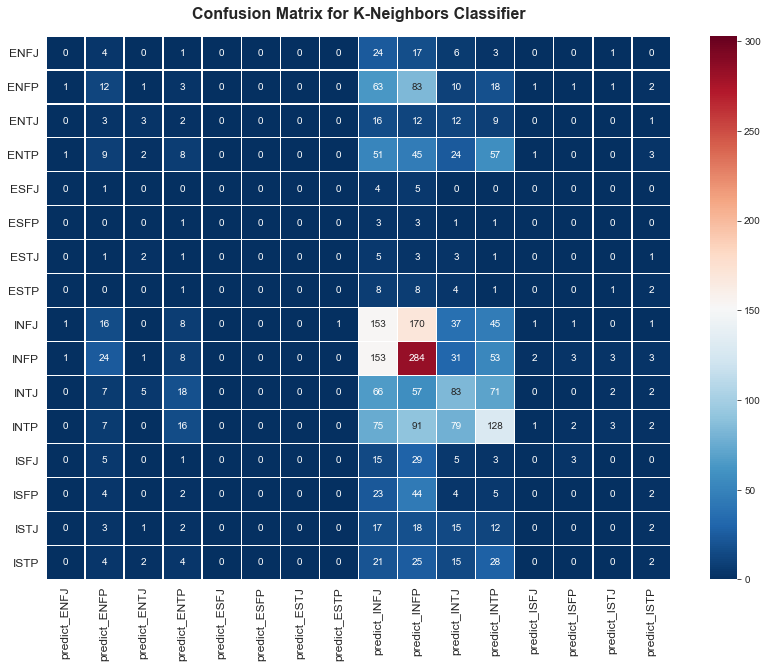

In [53]:

# Create confusion matrix heatmap of KNeighbors Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for K-Neighbors Classifier',
          fontweight='bold', y=1.02, fontsize=16)
sns.heatmap(cm_kneighbors, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

In [2]:

# Fit and score a One-Vs-The-Rest Classifier
ovrc = OneVsRestClassifier(LinearSVC(random_state=123))
ovrc.fit(X_train_tsvd, y_train)
print("TRAINING SET")
print("Accuracy: ", ovrc.score(X_train_tsvd, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, ovrc.predict(X_train_tsvd)))
print("Classification Report:")
print(classification_report(y_train, ovrc.predict(X_train_tsvd)))
print("")

print("TEST SET")
print("Accuracy: ", ovrc.score(X_test_tsvd, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ovrc.predict(X_test_tsvd)))
print("Classification Report:")
print(classification_report(y_test, ovrc.predict(X_test_tsvd)))

NameError: name 'OneVsRestClassifier' is not defined

In [56]:

# Convert confusion matrix to a dataframe to prepare it for heatmapping
cm_ovrc = np.array(confusion_matrix(y_test, ovrc.predict(X_test_tsvd)))

cm_onevsrest = pd.DataFrame(cm_ovrc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm_onevsrest

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,0,7,0,0,0,0,0,0,23,19,4,3,0,0,0,0
ENFP,0,42,1,11,0,0,0,0,33,82,8,16,0,2,0,1
ENTJ,0,3,4,14,0,0,0,0,11,7,15,4,0,0,0,0
ENTP,0,14,0,30,0,0,0,0,21,31,42,58,0,0,0,5
ESFJ,0,0,0,1,0,0,0,0,4,4,0,1,0,0,0,0
ESFP,0,2,0,0,0,0,0,0,1,2,0,3,0,0,0,1
ESTJ,0,1,0,0,0,0,0,0,3,3,5,3,0,0,0,2
ESTP,0,1,0,8,0,0,0,0,2,3,2,3,0,0,0,6
INFJ,0,20,1,10,0,0,0,0,161,164,38,34,0,1,0,5
INFP,0,23,1,12,0,0,0,0,78,381,26,43,1,1,0,0


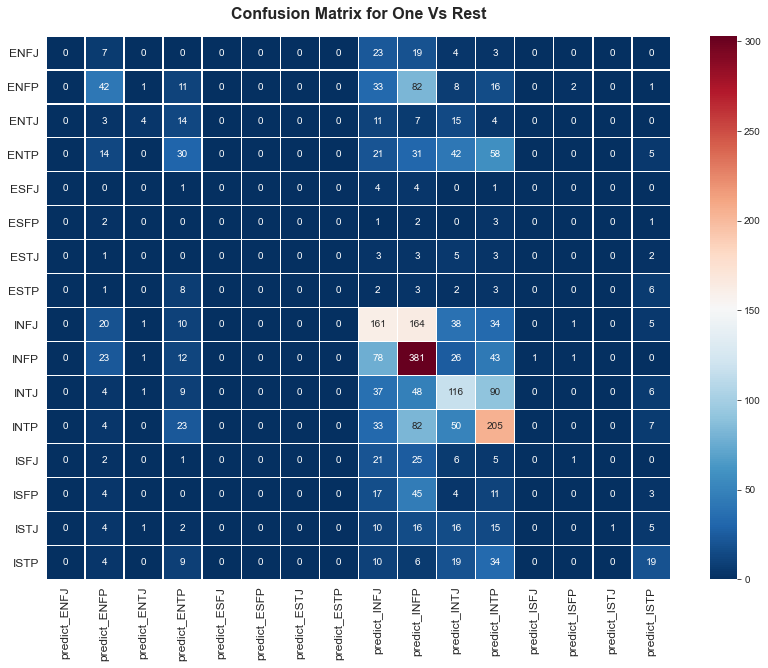

In [57]:
# Create confusion matrix heatmap of One vs. Rest model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for One Vs Rest',
          fontweight='bold', y=1.02, fontsize=16)
sns.heatmap(cm_onevsrest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12);

In [61]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model

Using TensorFlow backend.


In [80]:
df1

NameError: name 'df1' is not defined

In [73]:
y_train.shape

(6072,)

In [85]:
from sklearn.preprocessing import LabelEncoder

In [86]:
le=LabelEncoder()

In [88]:
df_copy=df

In [89]:
df_copy['code']=le.fit_transform(df_copy['type'])

In [90]:
df_copy.head

<bound method NDFrame.head of       type                                              posts  code
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     8
1     ENTP  'I'm finding the lack of me in these posts ver...     3
2     INTP  'Good one  _____   https://www.youtube.com/wat...    11
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...    10
4     ENTJ  'You're fired.|||That's another silly misconce...     2
...    ...                                                ...   ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...    13
8671  ENFP  'So...if this thread already exists someplace ...     1
8672  INTP  'So many questions when i do these things.  I ...    11
8673  INFP  'I am very conflicted right now when it comes ...     9
8674  INFP  'It has been too long since I have been on per...     9

[8675 rows x 3 columns]>

In [92]:
le.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [93]:
df_copy.drop(['type'],axis=1,inplace=True)

In [95]:
X_Train, X_Test, y_Train, y_Test = train_test_split(df_copy['posts'].values,
                                                   df_copy['code'].values,
                                                   test_size=0.30, random_state=42)
print('X_Train ', X_Train.shape, '\n', 'X_Test ', X_Test.shape, '\n', 'y_Train ', y_Train.shape, '\n', 
      'y_Test', y_Test.shape)

X_Train  (6072,) 
 X_Test  (2603,) 
 y_Train  (6072,) 
 y_Test (2603,)


In [96]:
# Pipeline for the data preprocessing steps (CountVectorizer, TruncatedSVD) on the X data
pipeline_preprocessing = make_pipeline(
   TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

X_Train = pipeline_preprocessing.fit_transform(X_Train)
X_Test = pipeline_preprocessing.transform(X_Test)

/Users/muskankuchhal/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [101]:
y_Train

array([10,  9, 10, ...,  8,  9, 10])